<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/New_Attack_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [114]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
import scipy.stats as st

from tqdm import tqdm
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import tensorflow
import numpy
import matplotlib.pyplot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [115]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [116]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Pre-procesing

## Get working df

In [117]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)
  
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

### Cutoff main

In [118]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df
  
def main_cutoff(input_path):
  print('Reading data from file.')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  df.iloc[0].fillna(method='bfill', inplace=True)
  df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  cut_point = cut_off_idx(df)
  working_df = select_working_data(df, cut_point)

  return working_df

In [119]:
#input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"
#orking_df = main_cutoff(input_path)
#display(working_df)

#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

## Get data

In [120]:
input_path = path + "/Spectrum/NN/new_data_working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [121]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

In [122]:
def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 3000):
  X=None
  Y=np.array([])
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]
  samples_df = pd.merge(dist_df, freq_df, left_index=True, right_index=True)
  samples_df = samples_df.sort_values(by='Distance_km')
  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 0].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 1:samples_df.shape[1]]
  
  return X, Y, samples_df

In [123]:
#input_data_path=path+"/rawData"
#distances=[i for i in range(1,26)]
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 50, span_length=80,  min_dist = 0, max_dist = 3000)

In [124]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-38.4375,-36.96875,-35.5,-34.03125,...,20.3125,21.78125,23.25,24.71875,26.1875,27.65625,29.125,30.59375,32.0625,33.53125
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-54.003601,-58.017553,-19.301894,-10.435002,...,-12.197162,-10.510367,-14.559612,-9.819478,-12.660800,-11.799207,-12.830698,-19.368740,-62.112421,-56.355953
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-68.783454,-69.066670,-18.329393,-10.547999,...,-12.318850,-10.461715,-2.662364,-12.267986,-16.581565,-9.727784,-15.047302,-18.879980,-60.212227,-56.509557
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-60.808791,-63.361479,-25.444994,-15.788745,...,-9.115456,-8.583339,-9.858284,-16.842030,-15.295197,-9.393247,-9.378545,-22.493220,-57.688354,-58.494920
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-64.296752,-51.517696,-20.699721,-8.626295,...,-14.141173,-13.268505,-12.008300,-11.065217,-11.676537,-8.246618,-12.804628,-18.591326,-58.150259,-64.950850
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.273160,-61.345464,-29.059103,-16.551420,...,-10.235052,-11.442021,-7.516882,-10.879396,-14.180488,-12.787280,-12.115514,-24.413964,-58.431556,-58.531077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-40.443805,-35.126729,-21.485364,-13.761653,...,-20.269016,-15.501216,-12.370308,-16.553390,-14.094575,-22.982161,-20.417287,-29.506823,-39.118395,-36.571468
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.308282,-33.267713,-19.777274,-17.627864,...,-11.883390,-15.025913,-13.957563,-9.734728,-14.005448,-12.203361,-21.857349,-28.857181,-31.226689,-33.082535
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-33.476511,-43.212130,-19.238315,-13.107622,...,-10.546151,-12.838006,-11.228312,-7.586014,-10.355436,-12.870469,-14.456255,-22.429850,-37.122217,-31.720817
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.157592,-34.679273,-20.850582,-11.863031,...,-4.201850,-8.752936,-6.067200,-14.008936,-12.015508,-10.472534,-12.476197,-29.950005,-33.442889,-35.509580


## Attack

In [125]:
# source_df = data that is wished to be modified
# target_df = data that the source would convert

source_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == 2000]
target_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == 80]

In [126]:
def get_eval_data(source_df, target_df, num_eval_samples = 10):
  import random
  source_val_list = [i for i in range(1, len(source_df))]
  source_random_list = random.choices(source_val_list, k = num_eval_samples)

  target_val_list = [i for i in range(1, len(target_df))]
  target_random_list = random.choices(target_val_list, k = num_eval_samples)

  eval_source_df = source_df.iloc[source_random_list]
  eval_target_df = target_df.iloc[target_random_list]

  return eval_source_df, eval_target_df

In [127]:
eval_source_df, eval_target_df = get_eval_data(source_df, target_df, num_eval_samples = 10)

In [128]:
def get_ci(df, alpha = 0.90):
  ci_arr = []
  for i in range(1, df.shape[1]):
    eval_col = df.iloc[:,i].to_numpy()
    source_ci = st.t.interval(alpha=alpha, df=len(eval_col)-1, loc=np.mean(eval_col), scale=st.sem(eval_col))
    ci_arr.append(source_ci)
  return ci_arr

In [129]:
source_ci_arr = get_ci(eval_source_df, alpha = 0.90)
target_ci_arr = get_ci(eval_target_df, alpha = 0.90)
print(source_ci_arr)

[(-37.27652349810587, -30.171290776446828), (-37.3924266079502, -33.026963058569024), (-38.71421793964684, -32.77196029416665), (-37.17660459518003, -33.36175328558982), (-37.62390481447587, -33.6260195406575), (-36.36971904768624, -32.490761480161886), (-38.24311534162698, -33.94953618115931), (-23.276236115399985, -19.448288825291325), (-14.105235358794236, -10.087960140985931), (-14.232945443030474, -8.85208631938513), (-12.487316821339066, -9.438506491884178), (-12.942675815298944, -9.660085399219449), (-13.437177413133567, -9.257861477558121), (-14.912664215105734, -10.021851651437412), (-16.160811872769255, -10.093473667408336), (-12.589489388948103, -9.458371127531109), (-13.329943073280356, -9.492362158544024), (-12.409179850889013, -8.82896117807444), (-10.801131153827674, -6.559828540857103), (-12.200803369759031, -8.617077298246214), (-14.07791404547009, -9.885848038936821), (-12.124766354086983, -7.66761670093117), (-12.734711462155614, -9.020007831428398), (-12.33520450155

In [130]:
eval_source_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-38.4375,-36.96875,-35.5,-34.03125,...,20.3125,21.78125,23.25,24.71875,26.1875,27.65625,29.125,30.59375,32.0625,33.53125
924,2000,-30.074150,-28.903182,-28.602393,-28.130953,-30.652741,-35.176001,-30.890968,-23.429165,-11.974461,...,-7.888137,-9.432376,-4.001771,-5.839490,-7.762652,-13.681315,-14.881241,-17.828288,-38.598669,-30.070988
174,2000,-48.491479,-36.878006,-31.016251,-34.208686,-35.799508,-37.360738,-41.046268,-20.131293,-9.409472,...,-13.433705,-8.115279,-17.194414,-8.846874,-12.207319,-8.118704,-11.307392,-24.472525,-34.487152,-36.011341
474,2000,-33.965398,-32.461275,-31.833409,-31.514901,-41.158250,-34.677163,-38.539098,-24.057114,-17.670334,...,-7.167339,-9.716480,-17.853421,-11.660336,-10.083343,-9.922807,-18.291875,-23.941361,-30.425372,-34.295917
1499,2000,-34.800096,-37.659274,-38.339240,-35.683097,-35.966495,-30.238897,-32.610812,-15.681621,-7.308605,...,-16.662835,-14.717042,-13.697310,-14.155725,-7.265676,-12.681117,-15.714099,-21.583394,-34.392394,-39.394384
699,2000,-36.438091,-35.663971,-35.542497,-36.577123,-32.891205,-37.484134,-34.593453,-21.304374,-10.138756,...,-10.596979,-14.883883,-6.906417,-7.339400,-12.377308,-8.165592,-13.396347,-25.870640,-35.180713,-32.247358
974,2000,-32.663891,-33.003006,-33.848126,-36.168176,-36.327195,-34.609950,-33.348739,-19.821842,-16.576395,...,-9.860227,-14.196584,-9.666424,-5.853195,-9.971797,-7.350428,-12.542770,-21.502207,-37.100864,-30.495096
1524,2000,-29.544189,-43.194318,-47.209049,-38.510477,-31.051352,-27.318041,-39.464628,-21.000926,-11.501781,...,-17.995125,-17.135252,-12.339681,-12.538565,-10.512094,-13.183410,-15.254862,-22.481331,-31.230804,-29.003545
2274,2000,-34.497729,-35.634032,-36.766787,-39.231696,-40.060484,-33.828378,-41.358603,-17.391275,-14.480628,...,-9.355422,-14.286336,-10.759193,-13.634176,-21.281463,-15.870233,-10.372620,-28.747156,-27.759324,-36.120125
1074,2000,-25.081635,-33.640693,-37.858861,-36.566523,-37.261497,-35.709952,-34.808915,-24.434743,-13.624644,...,-20.368463,-10.726237,-13.592115,-21.981016,-7.229000,-5.864865,-8.424085,-21.321944,-36.947963,-34.864827
499,2000,-31.682413,-35.059191,-36.414279,-36.100157,-35.080896,-37.899150,-34.301774,-26.370272,-8.280902,...,-3.428742,-9.740685,-10.763698,-7.080580,-9.895448,-18.120354,-13.606178,-18.813469,-37.655836,-30.891094


# Variational AutoEncoder

In [131]:
import tensorflow
import numpy
import matplotlib.pyplot

In [132]:
input_size = samples_filtered_df.shape[1] - 1

## encoder

In [133]:
latent_space_dim = 2

# Encoder
x = tensorflow.keras.layers.Input(shape=(input_size,), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="encoder_relu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_2")(encoder_activ_layer1)
encoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_2")(encoder_dense_layer2)

encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=32, name="encoder_dense_3")(encoder_activ_layer2)
encoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_3")(encoder_dense_layer3)

encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=16, name="encoder_dense_4")(encoder_activ_layer3)
encoder_activ_layer4 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_4")(encoder_dense_layer4)

encoder_dense_layer5 = tensorflow.keras.layers.Dense(units=16, name="encoder_dense_5")(encoder_activ_layer4)
encoder_activ_layer5 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_5")(encoder_dense_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

## decoder

In [134]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_input_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_input_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_input_layer1)

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=16, name="decoder_dense_1")(decoder_reshape)
decoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="decoder_relu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=32, name="decoder_dense_2")(decoder_activ_layer1)
decoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="decoder_relu_2")(decoder_dense_layer2)

decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_3")(decoder_activ_layer2)
decoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="decoder_relu_3")(decoder_dense_layer3)

decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=input_size, name="decoder_dense_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.ReLU(name="decoder_output")(decoder_dense_layer4)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

## vae

In [135]:
vae_input = tensorflow.keras.layers.Input(shape=(input_size), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 55)]              0         
                                                                 
 encoder_model (Functional)  (None, 2)                 10692     
                                                                 
 decoder_model (Functional)  (None, 55)                6551      
                                                                 
Total params: 17,243
Trainable params: 17,243
Non-trainable params: 0
_________________________________________________________________


## loss and compile

In [155]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

## load dataset

In [137]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-38.4375,-36.96875,-35.5,-34.03125,...,20.3125,21.78125,23.25,24.71875,26.1875,27.65625,29.125,30.59375,32.0625,33.53125
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-54.003601,-58.017553,-19.301894,-10.435002,...,-12.197162,-10.510367,-14.559612,-9.819478,-12.660800,-11.799207,-12.830698,-19.368740,-62.112421,-56.355953
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-68.783454,-69.066670,-18.329393,-10.547999,...,-12.318850,-10.461715,-2.662364,-12.267986,-16.581565,-9.727784,-15.047302,-18.879980,-60.212227,-56.509557
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-60.808791,-63.361479,-25.444994,-15.788745,...,-9.115456,-8.583339,-9.858284,-16.842030,-15.295197,-9.393247,-9.378545,-22.493220,-57.688354,-58.494920
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-64.296752,-51.517696,-20.699721,-8.626295,...,-14.141173,-13.268505,-12.008300,-11.065217,-11.676537,-8.246618,-12.804628,-18.591326,-58.150259,-64.950850
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.273160,-61.345464,-29.059103,-16.551420,...,-10.235052,-11.442021,-7.516882,-10.879396,-14.180488,-12.787280,-12.115514,-24.413964,-58.431556,-58.531077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-40.443805,-35.126729,-21.485364,-13.761653,...,-20.269016,-15.501216,-12.370308,-16.553390,-14.094575,-22.982161,-20.417287,-29.506823,-39.118395,-36.571468
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.308282,-33.267713,-19.777274,-17.627864,...,-11.883390,-15.025913,-13.957563,-9.734728,-14.005448,-12.203361,-21.857349,-28.857181,-31.226689,-33.082535
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-33.476511,-43.212130,-19.238315,-13.107622,...,-10.546151,-12.838006,-11.228312,-7.586014,-10.355436,-12.870469,-14.456255,-22.429850,-37.122217,-31.720817
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.157592,-34.679273,-20.850582,-11.863031,...,-4.201850,-8.752936,-6.067200,-14.008936,-12.015508,-10.472534,-12.476197,-29.950005,-33.442889,-35.509580


In [138]:
samples_filtered_df  = samples_filtered_df.query('Distance_km == 80')

In [139]:
x_train, x_test, y_train, y_test = train_test_split(samples_filtered_df.values[:, 1:samples_filtered_df.values.shape[1]], samples_filtered_df.values[:, 0], test_size=0.2, random_state=111)

In [140]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)

max_scaled = scaler.data_max_
min_scaled = scaler.data_min_

In [141]:
x_train = data_scaled.transform(x_train)
x_test = data_scaled.transform(x_test)

## train

In [ ]:
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

Training with 750 epochs ...


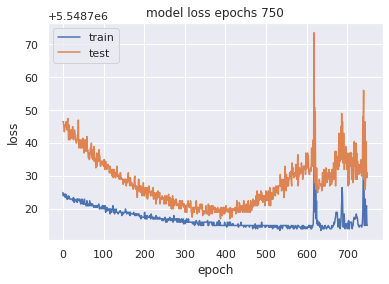

------------------------------------------------------
Training with 1000 epochs ...


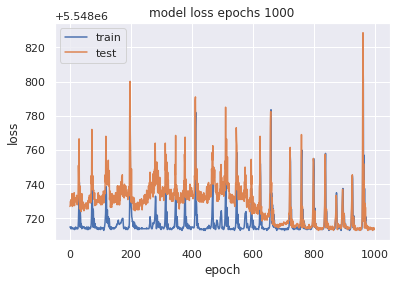

------------------------------------------------------


In [154]:
epochs_test = [750, 1000]
for et in epochs_test:
  print('Training with {} epochs ...'.format(et))
  history = vae.fit(x_train, y_train, epochs=et, batch_size=32, shuffle=True, validation_data=(x_test, y_test), verbose=0)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss epochs {}'.format(et))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # save autoencoder
  encoder.save(path+"/Spectrum/attack/autoencoder/VAE_encoder_epochs_"+str(et)+".h5") 
  decoder.save(path+"/Spectrum/attack/autoencoder/VAE_decoder_epochs_"+str(et)+".h5") 
  vae.save(path+"/Spectrum/attack/autoencoder/VAE_epochs_"+str(et)+".h5")

  print('------------------------------------------------------')

## test model

In [148]:
epochs_num = 200
encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_encoder_epochs_"+str(epochs_num)+".h5", compile=False)
decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_decoder_epochs_"+str(epochs_num)+".h5", compile=False)

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

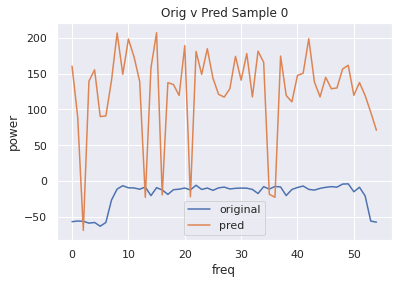

------------------------------------------------------


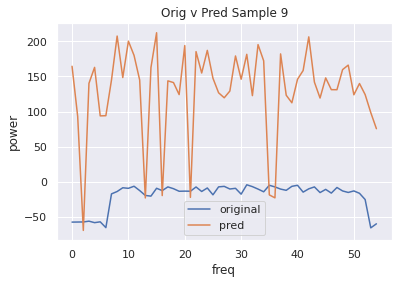

------------------------------------------------------


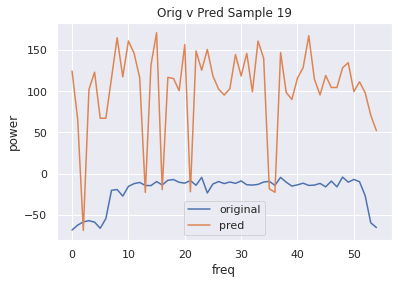

------------------------------------------------------


In [151]:
inverted_decoded_data = scaler.inverse_transform(decoded_data)
inverted_x_test = scaler.inverse_transform(x_test)

check_plots_samples = [0, 9, 19]
for cps in check_plots_samples:
  plt.plot(inverted_x_test[cps], label='original')
  plt.plot(inverted_decoded_data[cps], label='pred')
  plt.title('Orig v Pred Sample {}'.format(cps))
  plt.ylabel('power')
  plt.xlabel('freq')
  plt.legend(loc='best')
  plt.show()
  print('------------------------------------------------------')